# PROJECT OVERVIEW
The goal of this project is to implement FGSM and PGD attacks on MNIST datasets.
We will do this following the below steps:


1.   Loading the dateset and corresponding dataloader
2.   Loading a pretrained model from Huggingface
3.   Doing inferece on pretrained model
4.   Understanding each component of FGSM and PGD attack
5.   Implementing FGSM and PGD attack: add perturbation on test samples to fool the pretrained models into incorrect predictions
6.   Perturbed Sample visualizations
7.   Usage of Colab (Due to the usage limit of Colab free plan, we will use CPU runtime after reaching GPU usage limit. The pretrained model and dataset is very small for this work, can be done on CPU)

## Use of pip to install required modules


*   transformers.AutoModel for loading Huggingface pretrained models
*   torchvision.datasets, torchvision.transforms for loading and process datasets
*   matplotlib for visualization
*   torch for deep learning modeling



In [ ]:
!pip install transformers
!pip install torchvision
!pip install torch
!pip install matplotlib

##importing the required modules

In [2]:
from transformers import AutoModel
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
from torch import nn
import numpy as np

## Changing to the Colab GPU runtime!
First I clicked current runtime at top right. Selected "Change runtime type" and make sure the hardware accelerator is a GPU, e.g. "T4 GPU".

Then I set device to this GPU as following cell.

If the GPU usage of Colab has reached the limit, then we can CPU runtime instead.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## First Step
First, we will conduct our FGSM attack on MNIST (Modified National Institute of Standards and Technology database) dataset. MNIST contains a training set of 60,000 images and a test set of 10,000 images of handwritten digits. The handwritten digit images have been size-normalized and centered in a fixed size of 28×28 pixels. It contains 10 classes denoted digits from 0-9.

You need to implement

*   transform for data processing
*   load the MNIST test set
*   build the test dataloader with batchsize = 1

Hints are included before each code lines.



In [4]:
# ===============================================
# Data shape of MNIST image is 28*28. #
# However the pretrained model needs the input shape to be 1*(28*28) = 1*784 #
# We will find a proper torch function to flatten the 28*28 image to 1*784#

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1)),  # Flattening the image to 1*784
])


# ===============================================

dataset_path='data/'

# ===============================================

# Useingdatasets.MNIST to download and load the MNIST testset#
# include arguments: root (data save path dataset_path), train (trainingset or testset), download=True, transform = the transform you defined #
# checking the data size after implementation. Should be 10000 samples for mnist_test testset#
mnist_test = datasets.MNIST(root=dataset_path, train=False, download=True, transform=transform)

#only taking first 1000 samples for faster running
mnist_test = Subset(mnist_test, list(range(1000)))

# ===============================================

batch_size=1
# ===============================================
# Starting code here #
# using DataLoader for mnist_test, we need the shuffled data loader
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)
# Ending code here #
# ===============================================

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 897157.52it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134889.12it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1091939.46it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4555363.17it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## **Step 2**
Now, we will conduct our FGSM attack using a Huggingface pretrained model "dacorvo/mnist-mlp". It is a classification model for MNIST dataset. It takes 1*784 vector as the input and outputs Softmax logits.


*   Loading the Huggingface pretrained model



In [ ]:
# ===============================================
# Starting code here #
# Loading the model name "dacorvo/mnist-mlp" using AutoModel.from_pretrained#
# Adding the argument: trust_remote_code = True #
# Loading the model to defined GPU device #
model_name = "dacorvo/mnist-mlp"
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
# Ending code here #
# ===============================================

##**Step 3**
We will check the performance of model on clean testset before conducting attack.

In [6]:
# ===============================================
# Starting code here #
def evaluate(model, test_loader):
    correct = 0
    with torch.no_grad():
# getting image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
        for images, labels in test_loader:
            image = images.to(device)
            labels = labels.to(device)
# feeding the image to the model for output logit
            outputs = model(image)
# getting the predicted label
            predicted_label = outputs.argmax(-1).item()
# judging if the prediction is correct
            if predicted_label == labels.item():
              correct += 1
#calculating the accuracy and return the result
    accuracy = correct / len(test_loader)
    return accuracy
# Ending code here #
# ===============================================

print(f"The original accuracy of {model_name} on MNIST is:", evaluate(model,test_loader))

The original accuracy of dacorvo/mnist-mlp on MNIST is: 0.965


## **Step 4**
Implementing the FGSM (fast gradient sign method) attack:

$$x^{\prime}=x+\epsilon * \operatorname{sign}\left(\nabla_x J(\theta, x, l)\right)$$

to add purtabations $\epsilon * \operatorname{sign}\left(\nabla_x J(\theta, x, l)\right)$, where $\epsilon$ controls the magnitude of the perturbation, $\operatorname{sign}$ function extracts the direction while excludes the original gradient magnitude, $\nabla_x J(\theta, x, l)$ denotes the objective gradient towards the data.

The 3 arguments for fgsm_perturb function: image, epsilon, image_grad denote $x$, $\epsilon$, and $\nabla_x J(\theta, x, l)$ respectively.

We need the output perturbed_image as $x^{\prime}$.

We will generate perturbed adversarial image using FGSM attack algorithm.

In [7]:
# ===============================================
# Starting code here #
def fgsm_perturb(image, epsilon, image_grad):
    # getting signed image gradient using .sign()#
    sign_image_grad = torch.sign(image_grad)

    # getting the perturbation and add the perturbation to the clean image #
    perturbation = epsilon * sign_image_grad
    perturbed_image = image + perturbation

    # Returning the perturbed image#
    return perturbed_image
# Ending code here #
# ===============================================


## **Step 5**
Conducting the FGSM (fast gradient sign method) attack to the targeted dataset and model.

The 3 arguments for fgsm_perturb function: model, test_loader, epsilon denote targeted model, test MNIST dataloader, and $\epsilon$.

We need the output perturbed_images (perturbed images set), labels (clean images' prediction), perturbed_labels (perturbed images' prediction)

We will do the below

*   Perform model inference on clean images to get clean predictions and image_grad for fgsm_perturb function to get FGSM perturbed images.
*   Perform model inference on perturbed images to get prediction result after attack.


In [8]:
# ===============================================
# Starting code here #
def fgsm_attack(model, test_loader, epsilon):
    # Creating empty lists for perturbed_images (perturbed images set), labels (clean images' prediction set), perturbed_labels (perturbed images' prediction set)#
    perturbed_images = []
    labels = []
    perturbed_labels = []

    # getting image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
    for images, labels_batch in test_loader:
        image = images.to(device)
        label = labels_batch.item()
        image.requires_grad = True

        # feeding the image to the model for output logit #
        outputs = model(image)

        # getting the predicted label #
        predicted_label = outputs.argmax(-1).item()
        # defining the objective function for classfication (CrossEntropyLoss from torch.nn)#
        criterion = nn.CrossEntropyLoss()
        # computing loss using defined criterion #
        loss = criterion(outputs, torch.tensor([label]).to(device))
        model.zero_grad()
        loss.backward()
        # getting the gradient towards image data #
        image_grad = image.grad.data
        # Calling fgsm_perturb to add perturbation to the data
        perturbed_image = fgsm_perturb(image, epsilon, image_grad)
        # feeding the perturbed image to the model for output logit #
        perturbed_output = model(perturbed_image)
        # getting the predicted label #
        perturbed_label = perturbed_output.argmax(-1).item()

        perturbed_images.append(perturbed_image)
        labels.append(label)
        perturbed_labels.append(perturbed_label)

    # Returning the clean labels, perturbed images and perturbed images' labels
    return labels, perturbed_images, perturbed_labels
# Ending code here #
# ===============================================

## **Step 6**
Trying the implementation with different $ϵ$

Using the following cell to call the implementation to check attack performance with different $ϵ$.

Ploting the relationship between the model accuracy (fgsm_accuracy) and different epsilon (epsilon).

Checking what is the relationship between $ϵ$ and the attack performance.

## OBSERVATION
The relationship between ϵ and the attack performance can be observed from the results. As ϵ increases, the test accuracy decreases. This means that as the perturbation applied to the input images becomes stronger which comes from higher ϵ as per my understanding, attack strength or its impact increases, the model's accuracy decreases, meaning that the model becomes less robust against the adversarial perturbations introduced by the attack. In other words, higher values of ϵ lead to more significant changes in the input images, making it harder for the model to correctly classify them.
Therefore, I can say that ϵ is inversely proportional to the model accuracy but directly related to attack performance or impact of the attack. This is also evident from the plot. *italicized text*

Epsilon: 0.0,Test Accuracy: 0.965.
Epsilon: 0.04,Test Accuracy: 0.918.
Epsilon: 0.08,Test Accuracy: 0.844.
Epsilon: 0.12,Test Accuracy: 0.692.
Epsilon: 0.16,Test Accuracy: 0.49.
Epsilon: 0.2,Test Accuracy: 0.315.
Epsilon: 0.24,Test Accuracy: 0.199.


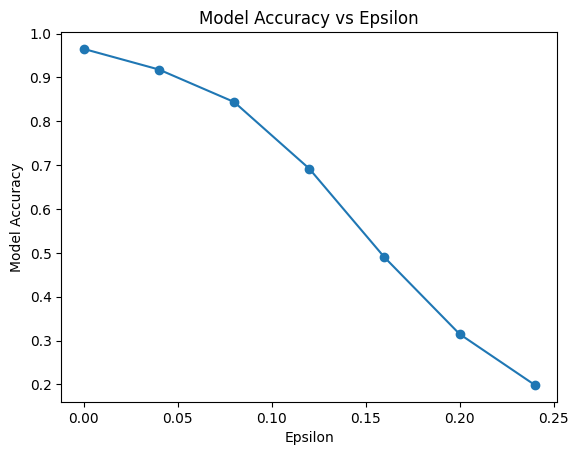

In [9]:
fgsm_accuracy = []
fgsm_perturbed_images = []
fgsm_clean_labels = []
fgsm_perturbed_labels = []
#Provided epsilons set, you can modify it to set.#
epsilons = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24]
for eps in epsilons:
    correct = 0
    labels, perturbed_images, perturbed_labels = fgsm_attack(model, test_loader, eps)
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
    accuracy = correct / len(test_loader)
    print(f"Epsilon: {eps},Test Accuracy: {accuracy}.")

    fgsm_accuracy.append(accuracy)
    fgsm_clean_labels.append(labels)
    fgsm_perturbed_images.append(perturbed_images)
    fgsm_perturbed_labels.append(perturbed_labels)

#Plotting the relationship between the model accuracy (fgsm_accuracy) and different epsilon (epsilon)#

# ===============================================
# Starting code here #
def plot_accuracy_eps(epsilons, accuracies):
    plt.plot(epsilons, accuracies, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Model Accuracy')
    plt.title('Model Accuracy vs Epsilon')
    plt.show()
# Ending code here #
# ===============================================
plot_accuracy_eps(epsilons,fgsm_accuracy)

## **Step 7**
Implementing visualization to show 5 samples for each $ϵ$ as well as indicating purtabled labels and groundtruth labels.

Also checking for the sample with wrong prediction, if the perturbation detectable using your eys even when the $ϵ$ is relatively large or not and what is the key component in FGSM to make the perturbation as slight as possible.

## OBSERVATION
For the samples with wrong predictions, even though the image quality is degraded, the number can be identified as the original number itself. At the first glance, the perturbations were not detectable to me with naked eyes, even if ϵ is relatively large. But if we look closely, we could see that there could be some perturbations visible, even though human brain can detect the right number.

Now, the key component in FGSM to make the perturbation as slight as possible:
To make the perturbation less noticeable, one key component is to keep ϵ small. By using a smaller ϵ, the perturbation introduced to the input image will be minimal, and the resulting adversarial example may appear visually similar to the original image, making the perturbation less detectable to the human eye.

Therefore, the key to minimizing the detectability of perturbations in FGSM is to strike a balance between the magnitude of the perturbation (controlled by ϵ) and the effectiveness of the attack in causing misclassification.

Although, the gradient also does play a role. While the epsilon parameter controls the magnitude of the perturbation, the gradient determines the direction of the perturbation.

In FGSM, we know that the goal is to generate a perturbation that maximizes the loss of the neural network while keeping the perturbation visually imperceptible. The gradient of the loss function with respect to the input image indicates how each pixel should be modified to increase the loss. By taking the sign of this gradient, FGSM ensures that the perturbation is applied in the direction that maximally increases the loss.

However, because FGSM only considers the sign of the gradient, it generates a perturbation with a fixed magnitude which is againdetermined by the epsilon parameter. This means that the gradient indirectly influences the magnitude of the perturbation through the epsilon parameter.

But the main role is played by the epsilon value. The smaller the epsilon value, the smaller the magnitude of the perturbation, resulting in a more slight perturbation overall.

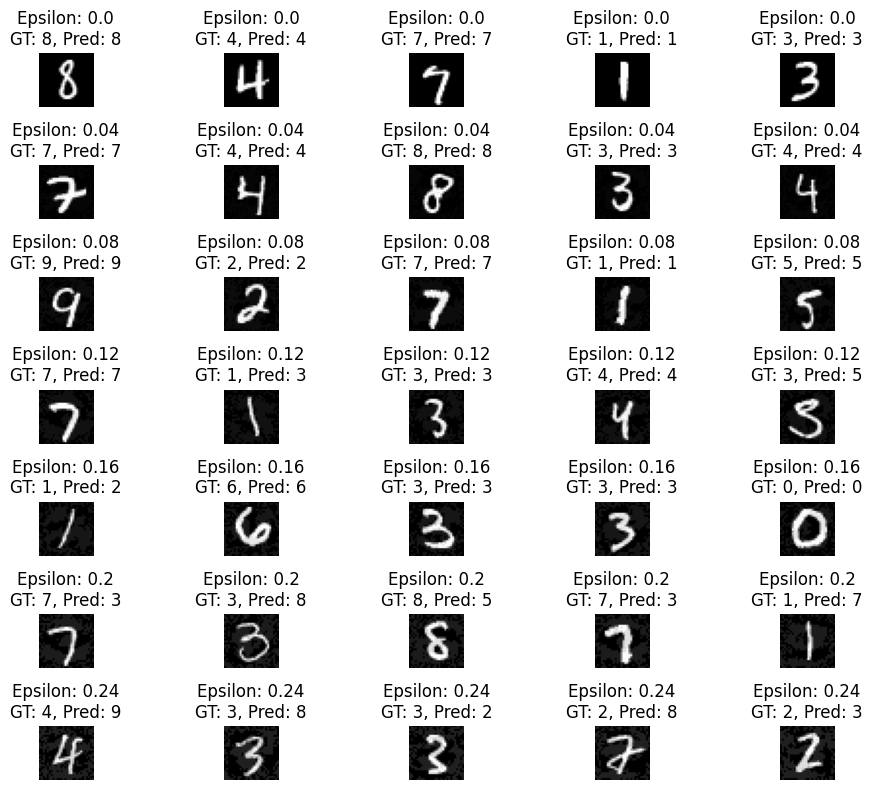

In [10]:
# Visualizing 5 examples of the adversarial samples for each epsilon as well as indicating purtabled labels and groundtruth labels
# ===============================================
# Starting code here #
#Here, I am introducing tensor so that the tensor can be converted to images
def tensor_to_image(tensor):
    numpy_image = tensor.detach().cpu().numpy()
    numpy_image = numpy_image.squeeze().reshape((28, 28))
    return numpy_image

#First, I am defining the arguments in the below function, these will take values from the previous function
original_labels = fgsm_clean_labels
prediction_labels = fgsm_perturbed_labels
adversarial_examples = fgsm_perturbed_images

def plot_perturbed_examples(epsilons, original_labels, prediction_labels, adversarial_examples):
    fig, axes = plt.subplots(len(epsilons), 5, figsize=(10, 8))


    for i, eps in enumerate(epsilons):
        for j in range(5):
#Here I am iterating over both the images and the labels
            original_label = original_labels[i][j].item() if hasattr(original_labels[i][j], 'item') else original_labels[i][j]
            prediction_label = prediction_labels[i][j].item() if hasattr(prediction_labels[i][j], 'item') else prediction_labels[i][j]
            adversarial_image = tensor_to_image(adversarial_examples[i][j])

#Now, we need to plot the images with their labels
            axes[i, j].imshow(adversarial_image, cmap='gray')
            axes[i, j].set_title(f"Epsilon: {eps}\nGT: {original_label}, Pred: {prediction_label}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Ending code here #
# ===============================================
plot_perturbed_examples(epsilons, original_labels, prediction_labels, adversarial_examples)


## **Step 8**
Implementing the PGD (Projected Gradient Descent) attack:

$$x^{t+1}=\Pi_{x+\mathcal{S}}\left(x^t+\alpha \operatorname{sign}\left(\nabla_x L(\theta, x, y)\right)\right)$$

, where $\Pi$ denote the projection operation, $y$ is the label. The projection operation ensures that if an updated input exceeds the constraint region, it is "projected" back into the allowable range.

Here, we take clipping images with $ϵ$ L-inf distance as $\Pi$, the pipeline of PGD attack is:


1.   Begining with $t=0$ ($x_0$ is the clean sample)
2.   Adding perturbation: $x_{t+1}=x_t+\alpha \cdot \operatorname{sign}(\nabla_{x_t} L(\theta, x_t, y))$
3.   Projecting perturbed sample within the constraint region: $x_{t+1}=\operatorname{clip}\left(x_{t+1}, x_0-\epsilon, x_0
+\epsilon\right)$
4.   Repeaingt $T$ iterations and end.

For 5 arguments of the pgd_perturb function to be implemented:


*   model: the loaded pretrained model for MNIST
*   image: the clean image to be attacked
*   label: the ground truth label for this image
*   epsilon: $ϵ$ mentioned in above step 3 denotes magnitude of constraint  region
*   alpha: $α$ mentioned in above step 2 denotes perturbation step size for PGD
*   iterations: $T$ the number of the iterations for PGD







We need to generate perturbed adversarial image using PGD attack algorithm.

In [11]:
# ===============================================
# Starting code here #
def pgd_perturb(model, image, label, epsilon, alpha, iterations):
    # iteration number #
    image = image.to(device)
    original_image = image  # Making a copy of the original image
    # iteration number #
    for i in range(iterations):
        image.requires_grad = True
        # feeding the image to the model for output logit #
        output = model(image)
        model.zero_grad()
        # defining the objective function for classfication (CrossEntropyLoss from torch.nn)#
        criterion = nn.CrossEntropyLoss()
        # computing loss using defined criterion #
        loss = criterion(output, torch.tensor([label]).to(device))
        loss.backward()
        # getting the signed gradient towards image data #
        sign_data_grad = torch.sign(image.grad.data)
        # implementing equation in step 2 to add perturbation at each iteration #
        perturbed_image = image + alpha * sign_data_grad
        # implementing equation in step 3 to project perturbed sample within the constraint region #
        perturbed_image = torch.max(torch.min(perturbed_image, original_image + epsilon), original_image - epsilon)
        image = perturbed_image.detach()  # Detaching the perturbed image to prevent gradient tracking

    return image
# Ending code here #
# ===============================================


## **Step 9**
Conducting the PGD (Projected Gradient Descent) attack to the targeted dataset and model.

The 5 arguments for pgd_perturb function: model, test_loader, epsilon, alpha, iterations denote targeted model, test MNIST dataloader, $\epsilon$, $\alpha$, and iteration number.

We need the output perturbed_images (perturbed images set), labels (clean images' prediction), perturbed_labels (perturbed images' prediction)

We need to follow the below:

*   Do model inference on clean images to get clean predictions
*   Get PGD perturbed images using defined pgd_perturb function.
*   Do model inference on perturbed images to get prediction result after attack.

In [12]:
# ===============================================
# Starting code here #
def pgd_attack(model, test_loader, epsilon, alpha, iterations):
    model.eval()
    # Creating empty lists for perturbed_images (perturbed images set), labels (clean images' prediction set), perturbed_labels (perturbed images' prediction set)#
    labels = []
    perturbed_images = []
    perturbed_labels = []
    # getting image and corresponding label iteratively and put image into GPU device. We set the batchsize = 1, so each iteration will give 1 sample #
    for images, labels_batch in test_loader:
        image = images.to(device)
        label = labels_batch.item()
        # Calling pgd_perturb to add perturbation to the data
        perturbed_image = pgd_perturb(model, image, label, epsilon, alpha, iterations)
        # feeding the perturbed image to the model for output logit #
        perturbed_output = model(perturbed_image)
        # getting the predicted label #
        perturbed_label = perturbed_output.argmax(dim=1).item()

        labels.append(label)
        perturbed_images.append(perturbed_image)
        perturbed_labels.append(perturbed_label)

    # Returning the clean labels, perturbed images and perturbed images' labels
    return labels, perturbed_images, perturbed_labels
# Ending code here #
# ===============================================

## **Step 10**
Try the implementation with different $ϵ$ or $α$ or iteration number. Sample $ϵ$, $α$ and iteration number are provided.

Using the following cell to calling the implementation to check attack performance with different $ϵ$ (or your selected argument between $ϵ$, $α$ and interation number).

Using or modifying implemented plot function in Task 6 to plot the relationship between the model accuracy (PGD_accuracy) and different $ϵ$ or α or iteration number.

Checking wwhat is the relationship between the selected arguments and the attack performance.

## **OBSERVATION**

When ϵ is small (e.g., 0.0 or 0.04), the attack perturbation is minimal, therefore, model accuracy is not decreased much. However, as ϵ increases (e.g., 0.08, 0.12, 0.2, 0.24), the perturbation becomes more significant, leading to a decrease in model accuracy.

Therefore, I can say that ϵ is inversely related to the model accuracy but directly related to attack performance or impact of the attack.

This is also evident from the plot. As ϵ increases, the test accuracy decreases. This means that as the perturbation applied to the input images becomes stronger which comes from higher ϵ as per my understanding, attack strength or its impact increases, the model's accuracy decreases, meaning that the model becomes less robust against the adversarial perturbations introduced by the attack. In other words, higher values of ϵ lead to more significant changes in the input images, making it harder for the model to correctly classify them.

A smaller ϵ may result in less noticeable perturbations but may also limit the attack's effectiveness, while a larger ϵ can produce more effective attacks but may result in more noticeable perturbations and lower model accuracy.

Epsilon: 0.0, Test Accuracy: 0.965.
Epsilon: 0.04, Test Accuracy: 0.917.
Epsilon: 0.08, Test Accuracy: 0.835.
Epsilon: 0.12, Test Accuracy: 0.66.
Epsilon: 0.16, Test Accuracy: 0.432.
Epsilon: 0.2, Test Accuracy: 0.252.
Epsilon: 0.24, Test Accuracy: 0.154.


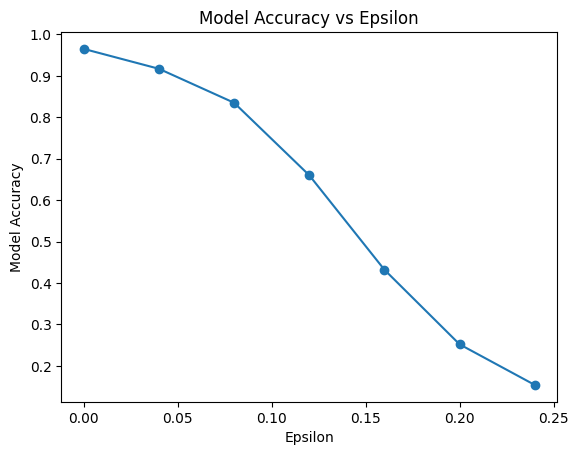

In [13]:
# Runing the PGD attack
pgd_accuracy = []
pgd_perturbed_images = []
pgd_clean_labels = []
pgd_perturbed_labels = []

# provided sample on different epsilon, try our setting
epsilons = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24]
alpha = 0.03
iterations = 8

for eps in epsilons:
    correct = 0
    labels, perturbed_images, perturbed_labels = pgd_attack(model, test_loader, eps, alpha, iterations)
    for i in range(len(perturbed_images)):
        if perturbed_labels[i] == labels[i]:
            correct += 1
    accuracy = correct / len(test_loader)
    print(f"Epsilon: {eps}, Test Accuracy: {accuracy}.")

    pgd_accuracy.append(accuracy)
    pgd_perturbed_images.append(perturbed_images)
    pgd_clean_labels.append(labels)
    pgd_perturbed_labels.append(perturbed_labels)

# Plotting the relationship between the model accuracy (pgd_accuracy) and between the selected arguments
# Using or modifying implemented plot function in Step 6

parameter_to_plot = epsilons

plot_accuracy_eps(parameter_to_plot, pgd_accuracy)

## **Step 11**
Using implemented plot function in Task 7 for visualization to show 5 samples for each $ϵ$ (or your selected argument between $ϵ$, $α$ and interation number) as well as indicating purtabled labels and groundtruth labels.

We will also check for the sample with wrong prediction, if the perturbation detectable using our eys even when the $ϵ$ (or the selected argument between $ϵ$, $α$ and interation number) is relatively large and what is the key component in PGD to make the perturbation as slight as possible.

## **OBSERVATION**
For the samples with wrong predictions, even though the image quality is degraded, the number can be identified as the original number itself. At the first glance, the perturbations were not detectable to me with naked eyes, even if ϵ is relatively large. But if we look closely, we could see that there could be some perturbations visible, even though human brain can detect the right number.


The key component in PGD to make the perturbation as slight as possible:

In PGD, the key component to making the perturbation as slight as possible is the step size or the learning rate and iteratively applying small perturbations used during the optimization process.

We have learnt that, PGD iteratively applies small perturbations to the input image while ensuring that the perturbed image remains within a certain epsilon (ε) bound. The step size determines how much the perturbation is adjusted in each iteration of the optimization process.

To make the perturbation as slight as possible in PGD, we try to choose a small step size. A small step size ensures that each perturbation applied to the input image is minimal, which helps in generating adversarial examples that are visually similar to the original input.

However, selecting an appropriate step size is a balancing act. If the step size is too small, the optimization process may converge slowly, requiring a large number of iterations to find an effective adversarial example. On the other hand, if the step size is too large, the perturbations may become too noticeable, leading to adversarial examples that are visually dissimilar to the original input.

Therefore, in PGD, the step size is a critical component in achieving a balance between generating slight perturbations and effectively fooling the neural network classifier.

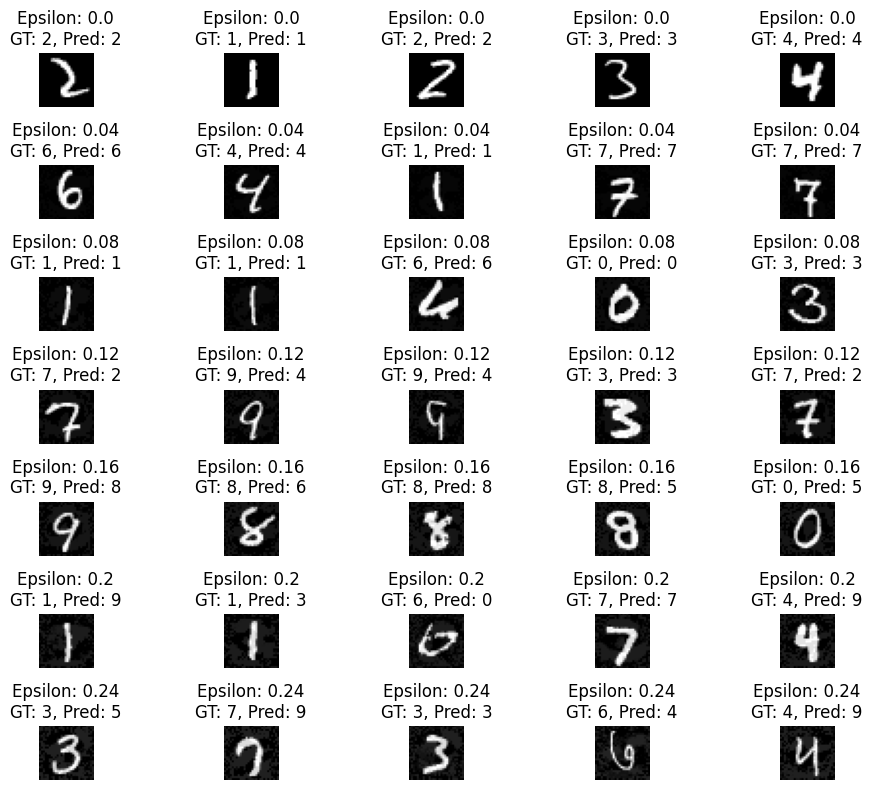

In [14]:
# Visualizing 5 examples of the adversarial samples for each epsilon (or the selected argument)
# as well as indicating perturbed labels and ground truth labels
plot_perturbed_examples(parameter_to_plot, pgd_clean_labels, pgd_perturbed_labels, pgd_perturbed_images)